In [1]:
import pickle
import torch
import numpy as np
import torchvision
import sys
sys.path.append("models")
from VGG_16 import VGG16
import os
import torchvision.transforms as transforms

from collections import Counter
from torch.utils.data import Subset

import torchvision.datasets as datasets
import random
import torch.utils.data as Data
from sklearn.cluster import KMeans
import numpy as np
import argparse
from model_mask_vgg import mask_VGG16
from sa_models import ConvnetMnist, ConvnetCifar, mask_ConvnetMnist, mask_ConvnetCifar
from get_a_single_path import getPath

batch_size = 64

transform_test = transforms.Compose([
        transforms.ToTensor(),
])

dataset = torchvision.datasets.CIFAR10(
        root = './data/cifar-10',
        train = False,
        transform = transform_test,
        download = False)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=False)

ori_model = VGG16(num_classes=10)
model_path = "./trained_models/model_vgg_cifar/vgg_seed32_dropout.pkl"
checkpoint = torch.load(model_path)
ori_model.load_state_dict(checkpoint)

ori_model = ori_model.cuda()
ori_model.eval()

num_cluster = 7

paths_all = []
for cla in range(10):
    paths_class = []
    for clu in range(num_cluster):
        picked_samples_fname = "cluster_paths/vgg_binary_cluster/num_cluster{}_threshold{}_class{}_cluster{}_paths.pkl".format(num_cluster, 0.8, cla, clu)
        with open(picked_samples_fname, "rb") as f:
            unpickler = pickle.Unpickler(f)
            path = unpickler.load()
            path = path[0]
            paths_class.append(path)
    paths_all.append(paths_class)
    
data_root = './adv_samples/adv_fgsm_cifar10_vgg_samples_eps0.02.npy'
label_root = './adv_samples/adv_fgsm_cifar10_vgg_labels_eps0.02.npy'

def get_adv_dataset(x, y):
    test_data = torch.from_numpy(x).float()
    test_label = torch.from_numpy(y).long()
    adv_dataset = torch.utils.data.TensorDataset(test_data,test_label)
    return adv_dataset

#load data
x = np.load(data_root)
x = x.transpose((0,3,1,2))
x = x/255.0
y = np.load(label_root)
#data_loader
adv_dataset = get_adv_dataset(x, y)
    


In [2]:
def sim_layer(unitsA, unitsB):
    u = list(set(unitsA) | set(unitsB))
    i = list(set(unitsA) & set(unitsB))
    return len(i)/len(u)

def similarity(pathsA, pathsB):
    sim = 0
    sims = []
    for layer in range(len(pathsA)):
        sim += sim_layer(pathsA[layer], pathsB[layer])
        sims.append(sim_layer(pathsA[layer], pathsB[layer]))
    sim = sim/len(pathsA)
    return sim, sims

def get_random(samples, num_picked, badboys=[]):
    picked = []
    indexs = []
    while len(picked) < num_picked:
        index = random.randint(0, len(samples)-1)
        if index not in indexs and index not in badboys:
            indexs.append(index)
            picked.append(samples[index])
    return picked

def get_similarity(samples1, samples2):
    s_all = 0.0
    sims_avg = np.array([0.0 for _ in range(len(paths[0]))])
    for s1 in samples1:
        p1 = paths[s1]
        for s2 in samples2:
            p2 = paths[s2]
            s, sims = similarity(p1, p2)
#             print(sims)
            s_all += s
            sims_avg = sims_avg + np.array(sims)       
    s_avg = s_all / (len(samples1) * len(samples2))
    return s_avg, sims_avg/(len(samples1) * len(samples2))

def get_similarity_samples_cluster(samples1, path2):
    s_all = 0.0
    num = 0.0
    sims_avg = np.array([0.0 for _ in range(len(paths[0]))])
    for s1 in samples1:
        p1 = paths[s1]
        p2 = path2
#         print("p1", [len(p) for p in p1])
#         print("p2", [len(p) for p in p2])
#         print("p1", p1)
#         print("p2", p2)
        s, sims = similarity(p1, p2)
#         print(s, sims)
        s_all += s
        num += 1
        sims_avg = sims_avg + np.array(sims)       
    s_avg = s_all / num
    return s_avg, sims_avg/num

In [3]:
def getSimi(index, dataset, other_label=False):
    
    data = dataset[index][0].unsqueeze(0).cuda()
    val_output = ori_model(data)
    val_pred_logit, val_pred_y = val_output.max(1)
    print("logit", val_output[0].data)
    if val_pred_y[0].item() != dataset[index][1]:
        print("wrong sample")
    if not other_label:
        paths = getPath(data, ori_model, 0.8)
        label = val_pred_y[0].item()
    else:
        paths = getPath(data, ori_model, 0.8, other_label=True, target=dataset[index][1])
        label = dataset[index][1].item()
    print("target", label)
    path = paths[0]
#     print(path)
    max_sim = 0
    for c in range(num_cluster):
        sim, sims = similarity(path, paths_all[label][c])
        if sim > max_sim:
            max_sim = sim
            max_sims = sims
    print(sim, sims)

In [4]:
index = 10
getSimi(index, dataset)

logit tensor([ 4.1500, -2.2695, -1.2515, -0.7248, -1.4714, -1.6962, -7.1486, -1.4607,
         0.2912, -0.7642], device='cuda:0')
relevance_tensor tensor([[12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], device='cuda:0')
[tensor([[[[0.0000, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000]],

         ...,

         [[0.0000, 0.0000],
          [0.0000, 0.2084]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000]]]]), tensor([[[[0.0000, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000]],

         ...,

         [[0.0000, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 3.8148],
          [0.0000, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000]]]]), tensor([[[[0., 0.],
          [0., 0.]],

  

In [43]:
getSimi(index, adv_dataset)

logit tensor([-13.3686,  -5.6958,  -3.4963,   0.1108,  -1.5483,   8.8678,  -2.1334,
         -3.2967,  -3.8673,  -6.3923], device='cuda:0')
wrong sample
target 5
[[2, 1, 36, 37, 31, 10, 27, 28, 19, 35, 42, 18], [19, 43, 28, 57, 56, 5, 36, 32, 10, 52, 39, 6, 22, 18, 25, 35, 50, 21, 40, 45, 17, 58, 4, 51, 15, 24, 42, 12, 48, 53, 41], [91, 36, 9, 24, 54, 35, 97, 46, 126, 17, 12, 92, 105, 110, 2, 16, 66, 104, 84, 69, 19, 99, 30, 118, 107, 63, 86, 8, 65, 88, 13, 21, 111, 120, 95, 23, 108, 14, 79, 31, 112, 3, 76], [101, 2, 92, 113, 27, 88, 42, 99, 38, 106, 68, 71, 77, 34, 66, 79, 69, 16, 0, 53, 32, 57, 56, 9, 31, 81, 93, 86, 123, 110, 33, 83, 26, 89, 82, 24, 116, 67, 45, 47, 10, 85, 8, 3, 108, 6, 30, 21, 124], [22, 207, 192, 67, 72, 176, 236, 8, 27, 209, 30, 253, 130, 237, 24, 3, 169, 223, 129, 161, 158, 197, 196, 80, 186, 125, 165, 205, 14, 227, 79, 69, 95, 4, 64], [210, 61, 209, 109, 41, 139, 32, 201, 199, 246, 20], [246, 9, 133, 53, 205, 117, 106, 15], [299, 133, 339, 42, 128, 476], [309,

In [42]:
getSimi(index, adv_dataset, other_label=True)

logit tensor([-13.3686,  -5.6958,  -3.4963,   0.1108,  -1.5483,   8.8678,  -2.1334,
         -3.2967,  -3.8673,  -6.3923], device='cuda:0')
wrong sample
target 0
[[26, 58, 43], [49], [72, 38, 27, 77], [12, 58], [229, 142, 126, 203, 100, 12, 135, 181, 98, 93, 121, 92, 140, 188, 81, 182, 57, 233], [114, 174, 111, 181, 180, 231, 52, 38, 140], [45, 65, 80, 43, 34, 152, 104, 241, 186, 231], [503, 447, 264, 114, 431], [193, 48, 335, 412, 446], [408, 147, 345, 374, 361, 211], [42, 141, 86, 63], [390], [152, 249, 37, 176, 117, 454, 424, 418, 127, 250, 148, 209, 118, 242, 139, 463, 166, 308, 157, 466, 130, 277]]
0.06815114709851552 [0.0, 0.0, 0.0, 0.0, 0.07142857142857142, 0.08333333333333333, 0.05263157894736842, 0.0, 0.0, 0.42857142857142855, 0.25, 0.0, 0.0]


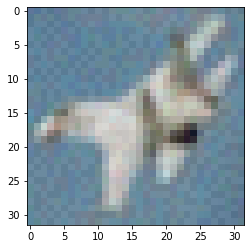

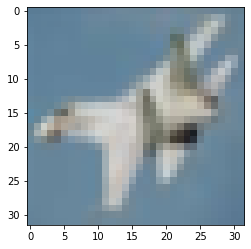

In [38]:

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

toPIL = transforms.Compose([transforms.ToPILImage()])
plt.imshow(toPIL(adv_dataset[index][0]))
plt.show()
toPIL = transforms.Compose([transforms.ToPILImage()])
plt.imshow(toPIL(dataset[index][0]))
plt.show()

In [3]:
a = "1/2/3/4/dfsaf"
a = a.replace("/", "")
print(a)

1234dfsaf


In [1]:
import pickle
import torch
import numpy as np
import torchvision
import sys
sys.path.append("models")
from VGG_16 import VGG16
import os
import torchvision.transforms as transforms

from collections import Counter
from torch.utils.data import Subset

import torchvision.datasets as datasets
import random
import torch.utils.data as Data
from sklearn.cluster import KMeans
import numpy as np
import argparse
from model_mask_vgg import mask_VGG16
from sa_models import ConvnetMnist, ConvnetCifar, mask_ConvnetMnist, mask_ConvnetCifar
from get_a_single_path import getPath

batch_size = 6400

transform_test = transforms.Compose([
        transforms.ToTensor(),
])

dataset = torchvision.datasets.CIFAR10(
        root = './data/cifar-10',
        train = True,
        transform = transform_test,
        download = False)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=False)

ori_model = VGG16(num_classes=10)
model_path = "./trained_models/model_vgg_cifar/vgg_seed32_dropout.pkl"
checkpoint = torch.load(model_path)
ori_model.load_state_dict(checkpoint)

ori_model = ori_model.cuda()
ori_model.eval()
total = 0

max_logits = 0

with torch.no_grad():
    for test_step, (val_x, val_y) in enumerate(data_loader):
        print("step:", test_step)
        val_x = val_x.cuda()
        val_y = val_y.cuda()
        val_output = ori_model(val_x)
        val_pred_logit, val_pred_y = val_output.max(1)
        
        max_logits += val_pred_logit.sum().data
        
        if test_step == 0:
            correct = val_pred_y.eq(val_y).sum().item()
        else:
            correct += val_pred_y.eq(val_y).sum().item()
            
        total += val_y.size(0)
result = float(correct) * 100.0 / float(total)
print(result)
print('logit_sum:', max_logits)

step: 0
step: 1
step: 2
step: 3
step: 4
step: 5
step: 6
step: 7
95.676
logit_sum: tensor(384086.8750, device='cuda:0')


In [22]:
import torchvision.transforms as transforms
import torchvision
import numpy as np
import torch
import tqdm
from models.VGG_16 import VGG16

transform_test = transforms.Compose([
        transforms.ToTensor(),
])

train_set = torchvision.datasets.CIFAR10(
        root = './data/cifar-10',
        train = True,
        transform=transform_test,
        download = False)

dataset = train_set.data
dataset = dataset.astype("float32")
ori_model = VGG16(num_classes=10)
model_path = "./trained_models/model_vgg_cifar/vgg_seed32_dropout.pkl"
checkpoint = torch.load(model_path)
ori_model.load_state_dict(checkpoint)

ori_model = ori_model.cuda()
ori_model.eval()

if type(dataset)==np.ndarray :
    print ("---"*8,dataset.shape,"---")
    dataset = torch.from_numpy(dataset).transpose(2,3).transpose(1,2)
    print(dataset.max(),dataset.min())
    dataset =torch.utils.data.TensorDataset(dataset)
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=64,num_workers=0,drop_last=False)

    dataloader = enumerate(dataloader )
with torch .no_grad() :
    if dataloader is not None :
        logits_out_list= []
        for idx,data  in tqdm.tqdm(dataloader) :
            if type(data)==list:
                data= data[0]
            data =data .cuda()
            logits_out_one = ori_model.forward( data)
            logits_out_list .append( logits_out_one )
        logits_out = torch.cat(logits_out_list,dim=0)
    else :
        logits_out = self.net.forward(dataset)
#logits_out = torch.softmax(logits_out)

pred_class = logits_out .argmax(-1)
pred_class = clear_method(pred_class)
print((pred_class==1).sum())
print("\tfinished!")

------------------------ (50000, 32, 32, 3) ---


1it [00:00,  8.35it/s]

tensor(255.) tensor(0.)


532it [01:06,  7.95it/s]


KeyboardInterrupt: 